Abusive Sarcasm Detection in Text.

-> We didn't had dataset that had labeled text as abusive and sarcastic. We did find data that labeled text in a degree of toxicity and sarcasm/non-sarcasm separately.

-> We decided to use these separate dataset and create a new dataset with toxic and sarcastic label.

-> Initial approach to create a new dataset was to add all zero sarcastic column in abusive dataset and all zero abusive column in sarcastic dataset. Meaning, we assumed that non of the abusive data points are sarcastic and non of the sarcatic data points are abusive. This is highly likely to be wrong assumpution.

-> Another issue we faced was that there where not as many toxic/abusive labeled data as compared to sarcasm data. So, new dataset was quite unbalanced.

-> We had to balance the dataset.

-> We used BERT based language model on the text to perform multi label classification.

-> Since, we had wrong assumption regarding the datapoints in the dataset, to imporve our assumpotion we created separate bert based model for abusive text detection and another for sarcastic text detection. The we crossed the sarcastic dataset with abusive model to get sarcastic prediction for abusive model and crossed the abusive dataset with sarcastic model to get abusive prediction for sarcatic model. The we combined these dataset as earlier. Although, not totally accurate labeled dataset, it is still better than our initial all zero assumptions.

[count analysis on dataset]

-> Again we used BERT based language model on the text to perform multi label classification on new dataset.

->Gradio app.

In [ ]:
pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 48.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 86.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 kB 16.1 MB/s eta 0:00:00


In [ ]:
import os
import re
import numpy as np
import pandas as pd
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

import transformers
from transformers import BertTokenizer, BertModel
from transformers import RobertaTokenizer, RobertaModel

import torch
from torch import cuda
from tqdm import tqdm_notebook as tqdm
device = 'cuda' if cuda.is_available() else 'cpu'

device

'cuda'

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
manually_testdata=pd.read_csv('/content/gdrive/MyDrive/Untitled folder/manually_annotated_dataset - Sheet1.csv',on_bad_lines='skip')
manually_testdata = shuffle(manually_testdata)
manually_testdata  = manually_testdata[manually_testdata['text'].notna()]
manually_testdata= manually_testdata.reset_index(drop=True)
manually_testdata['toxic']=manually_testdata['toxic'].astype(int)
manually_testdata['sarcastic']=manually_testdata['sarcastic'].astype(int)
manually_testdata

,text,toxic,sarcastic
0,"People say nothing is impossible, but I do not...",0,1
1,I hate low caste hindus,1,0
2,"The last time I saw a face like yours, I fed i...",1,1
3,You are the reason why shampoo has instructions.,1,1
4,I'm really looking forward to working with som...,0,1
...,...,...,...
107,The class is pretty boring. I feel like my tim...,0,0
108,I hate black people,1,0
109,Women should be kept on a tight leash,1,0
110,It was a long and tiring day for me. I need a ...,0,0


In [ ]:
zero_col_data=pd.read_csv('/content/gdrive/MyDrive/Untitled folder/processed_abusive_sarcasm_data.csv',on_bad_lines='skip')
zero_col_data = shuffle(zero_col_data)
zero_col_data  = zero_col_data[zero_col_data['processed_text'].notna()]
zero_col_data= zero_col_data.reset_index(drop=True)
zero_col_data

,text,toxic,sarcastic,processed_text
0,Oh fuck I didn't even realize that I didn't fl...,0,0,oh fuck even realize flair artwork work top le...
1,jon kate plus http tlc discovery com tv schedu...,0,0,jon kate plus http tlc discovery com tv schedu...
2,"Akali Combo Hey, Akali mains. I have a quick q...",0,1,akali combo hey akali main quick question rece...
3,Fucking TOs killing us. Could have been 14 poi...,0,1,fuck tos kill u could point fumble yard line y...
4,"fucking hell, you fucking mong!",1,0,fuck hell fucking mong
...,...,...,...,...
408929,photograph can we have a photo of such a family,0,0,photograph photo family
408930,The CS rep does say the problem though - that'...,0,1,c rep say problem though valid win key work fo...
408931,Flags for an American Canadian Union Why could...,0,1,flag american canadian union simply add st star
408932,"The first review was glorious! ""All it is, is ...",0,0,first review glorious l e suction cup would buy


In [ ]:
pred_col_data=pd.read_csv('/content/gdrive/MyDrive/Untitled folder/processed_abusive_sarcasm_data_with_prediction.csv',on_bad_lines='skip')
pred_col_data = shuffle(pred_col_data)
pred_col_data  = pred_col_data[pred_col_data['processed_text'].notna()]
pred_col_data= pred_col_data.reset_index(drop=True)
pred_col_data=pred_col_data.drop(['Unnamed: 0'],axis=1)
pred_col_data

,text,toxic,sarcastic,processed_text
0,"I told u I'm a psychopath Yeah, OP, *Common*!",0,1,tell u psychopath yeah op common
1,not similar to racial purity i m having diffi...,0,0,similar racial purity difficulty see dissimila...
2,Key supplies of Brazilian currency run out... ...,0,1,key supply brazilian currency run would guess ...
3,Son leaves a note A father passing by his son'...,0,0,son leave note father pass son bedroom astonis...
4,All pussies. Except the chubby kid. Sucker pun...,0,1,pussy except chubby kid sucker punch sucker pu...
...,...,...,...,...
408929,6 year old has elaborate memory of sister's se...,0,1,year old elaborate memory sister self harm tum...
408930,I don't know if he stole something or not. I d...,1,1,know steal something know good person opinion ...
408931,Can anybody find the problem with this free ag...,0,1,anybody find problem free agent ya dfd weigh lb
408932,RT @BOSSBITCH122513: Loyalty now let's get thi...,1,1,rt bossbitch loyalty let get money get u u get...


In [ ]:
zero_col_data['toxic'].value_counts(),pred_col_data['toxic'].value_counts()

(0    348654
 1     60280
 Name: toxic, dtype: int64,
 0    297556
 1    111378
 Name: toxic, dtype: int64)

In [ ]:
60280/408934, 111378/408934

(0.1474076501342515, 0.2723617992145432)

In [ ]:
zero_col_data['sarcastic'].value_counts(),pred_col_data['sarcastic'].value_counts()

(0    306747
 1    102187
 Name: sarcastic, dtype: int64,
 0    247922
 1    161012
 Name: sarcastic, dtype: int64)

In [ ]:
102187/408934, 161012/408934

(0.24988628971912338, 0.39373590848400963)

In [ ]:
def train_test_split(df, train_percent=0.7, seed=None):
    np.random.seed(seed)
    perm = np.random.permutation(df.index)
    m = len(df.index)
    train_end = int(train_percent*m)
    train = df.iloc[perm[:train_end]]
    test = df.iloc[perm[train_end:]]
    return train, test

In [ ]:
zero_col_train,zero_col_test =train_test_split(zero_col_data, seed=123)
pred_col_train,pred_col_test =train_test_split(pred_col_data, seed=123)

In [ ]:
zero_col_train.to_csv('/content/gdrive/MyDrive/Untitled folder/zero_col_train.csv', index=False)
zero_col_test.to_csv('/content/gdrive/MyDrive/Untitled folder/zero_col_test.csv', index=False)
pred_col_train.to_csv('/content/gdrive/MyDrive/Untitled folder/pred_col_train.csv', index=False)
pred_col_test.to_csv('/content/gdrive/MyDrive/Untitled folder/pred_col_test.csv', index=False)

In [ ]:
zero_col_train_path="/content/gdrive/MyDrive/Untitled folder/zero_col_train.csv"
zero_col_test_path="/content/gdrive/MyDrive/Untitled folder/zero_col_test.csv"
pred_col_train_path="/content/gdrive/MyDrive/Untitled folder/pred_col_train.csv"
pred_col_test_path="/content/gdrive/MyDrive/Untitled folder/pred_col_test.csv"

In [ ]:
zero_col_train_X=zero_col_train['processed_text']
zero_col_train_y=zero_col_train[['toxic', 'sarcastic']]
zero_col_test_X=zero_col_test['processed_text']
zero_col_test_y=zero_col_test[['toxic', 'sarcastic']]
pred_col_train_X=pred_col_train['processed_text']
pred_col_train_y=pred_col_train[['toxic', 'sarcastic']]
pred_col_test_X=pred_col_test['processed_text']
pred_col_test_y=pred_col_test[['toxic', 'sarcastic']]

In [ ]:
mt_X=manually_testdata['text']
mt__y=manually_testdata[['toxic', 'sarcastic']]

In [ ]:
mt__y=mt__y.to_numpy()

In [ ]:
zero_col_train_X=zero_col_train_X.reset_index(drop=True)
zero_col_train_y=zero_col_train_y.reset_index(drop=True)
zero_col_test_X=zero_col_test_X.reset_index(drop=True)
zero_col_test_y=zero_col_test_y.reset_index(drop=True)
pred_col_train_X=pred_col_train_X.reset_index(drop=True)
pred_col_train_y=pred_col_train_y.reset_index(drop=True)
pred_col_test_X=pred_col_test_X.reset_index(drop=True)
pred_col_test_y=pred_col_test_y.reset_index(drop=True)

In [ ]:
zero_col_train_y=zero_col_train_y.to_numpy()
zero_col_test_y=zero_col_test_y.to_numpy()
pred_col_train_y=pred_col_train_y.to_numpy()
pred_col_test_y=pred_col_test_y.to_numpy()

In [ ]:
len(zero_col_train_X), len(zero_col_train_y), len(zero_col_test_X), len(zero_col_test_y)

(286253, 286253, 122681, 122681)

In [ ]:
len(pred_col_train_X), len(pred_col_train_y), len(pred_col_test_X), len(pred_col_test_y)

(286253, 286253, 122681, 122681)

In [ ]:
labels = {
    0:'Toxic',
    1:'Sarcastic',
}
len(labels)

2

In [ ]:
class MultiLabelDataset(torch.utils.data.Dataset):

    def __init__(self, text, labels, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.text = text
        self.targets = labels
        self.max_len = max_len

    def __len__(self):
        return len(self.text)

    def __getitem__(self, index):
        text = self.text[index]
        inputs = self.tokenizer.encode_plus(
            text,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            pad_to_max_length=True,
            truncation=True,
            return_token_type_ids=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        token_type_ids = inputs["token_type_ids"]


        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            'targets': torch.tensor(self.targets[index], dtype=torch.long)
        }

In [ ]:
class BERTClass(torch.nn.Module):
    def __init__(self, NUM_OUT):
        super(BERTClass, self).__init__()
                   
        self.l1 = BertModel.from_pretrained("bert-base-uncased")
        self.classifier = torch.nn.Linear(768, NUM_OUT)
        self.dropout = torch.nn.Dropout(0.3)
        self.softmax = torch.nn.Softmax(dim=1)

    def forward(self, input_ids, attention_mask, token_type_ids):
        output_1 = self.l1(input_ids=input_ids, attention_mask=attention_mask)
        hidden_state = output_1[0]
        pooler = hidden_state[:, 0]
        pooler = self.dropout(pooler)
        output = self.classifier(pooler)
        output = self.softmax(output)
        return output

In [ ]:
def loss_fn(outputs, targets):
    with torch.autocast('cuda'):
      loss=torch.nn.BCEWithLogitsLoss()(outputs, targets.float())
    return loss

def train(model, training_loader, optimizer):
    model.train()
    for data in tqdm(training_loader):
        ids = data['ids'].to(device, dtype = torch.long)
        mask = data['mask'].to(device, dtype = torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
        targets = data['targets'].to(device, dtype = torch.long)
        outputs = model(ids, mask, token_type_ids)
        optimizer.zero_grad()
        loss = loss_fn(outputs, targets)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    return loss
    
def validation(model, testing_loader):
    model.eval()
    fin_targets=[]
    fin_outputs=[]
    with torch.no_grad():
        for data in testing_loader:
            targets = data['targets']
            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
            outputs = model(ids, mask, token_type_ids)
            outputs = torch.sigmoid(outputs).cpu().detach()
            fin_outputs.extend(outputs)
            fin_targets.extend(targets)
    return torch.stack(fin_outputs), torch.stack(fin_targets)

In [ ]:
def tester(model, testing_loader):
    model.eval()
    fin_targets=[]
    fin_outputs=[]
    with torch.no_grad():
        for data in testing_loader:
            targets = data['targets']
            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
            outputs = model(ids, mask, token_type_ids)
            outputs = torch.sigmoid(outputs).cpu().detach()
            fin_outputs.extend(outputs)
            fin_targets.extend(targets)
    
    # Calculate the accuracy of the model on the test set
    fin_outputs = torch.stack(fin_outputs)
    fin_targets = torch.stack(fin_targets)
    threshold = 0.5
    predicted_labels = (fin_outputs > threshold).int()
    accuracy = (predicted_labels == fin_targets).sum().item() / (len(fin_targets) * len(fin_targets[0]))
    
    return fin_outputs, fin_targets, accuracy


In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
MAX_LEN = 128
BATCH_SIZE = 64
EPOCHS = 3
NUM_OUT = 2
LEARNING_RATE = 2e-05

zero_col_training_data = MultiLabelDataset(zero_col_train_X, torch.from_numpy(zero_col_train_y), tokenizer, MAX_LEN)
zero_col_test_data = MultiLabelDataset(zero_col_test_X, torch.from_numpy(zero_col_test_y), tokenizer, MAX_LEN)
pred_col_training_data = MultiLabelDataset(pred_col_train_X, torch.from_numpy(pred_col_train_y), tokenizer, MAX_LEN)
pred_col_test_data = MultiLabelDataset(pred_col_test_X, torch.from_numpy(pred_col_test_y), tokenizer, MAX_LEN)

train_params = {'batch_size': BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

test_params = {'batch_size': BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }    

zero_col_training_loader = torch.utils.data.DataLoader(zero_col_training_data, **train_params)
zero_col_testing_loader = torch.utils.data.DataLoader(zero_col_test_data, **test_params)
pred_col_training_loader = torch.utils.data.DataLoader(pred_col_training_data, **train_params)
pred_col_testing_loader = torch.utils.data.DataLoader(pred_col_test_data, **test_params)

In [ ]:
manualtestdata=MultiLabelDataset(mt_X, torch.from_numpy(mt__y), tokenizer, MAX_LEN)
manual_Tester = torch.utils.data.DataLoader(manualtestdata, **test_params)

In [ ]:
zero_col_model = BERTClass(NUM_OUT)
zero_col_model.to(device)    
optimizer = torch.optim.Adam(params = zero_col_model.parameters(), lr=LEARNING_RATE)
for epoch in range(EPOCHS):
    loss = train(zero_col_model, zero_col_training_loader, optimizer)
    print(f'Epoch: {epoch}, Loss:  {loss.item()}')  

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
<ipython-input-43-a636cc2ba7d4>:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tq

  0%|          | 0/4473 [00:00<?, ?it/s]

/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:2354: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
<ipython-input-41-2dcf1d0c191a>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'targets': torch.tensor(self.targets[index], dtype=torch.long)


Epoch: 0, Loss:  0.7576661109924316


  0%|          | 0/4473 [00:00<?, ?it/s]

Epoch: 1, Loss:  0.7997933626174927


  0%|          | 0/4473 [00:00<?, ?it/s]

Epoch: 2, Loss:  0.7877270579338074


In [ ]:
pred_col_model = BERTClass(NUM_OUT)
pred_col_model.to(device)    
optimizer = torch.optim.Adam(params = pred_col_model.parameters(), lr=LEARNING_RATE)
for epoch in range(EPOCHS):
    loss = train(pred_col_model, pred_col_training_loader, optimizer)
    print(f'Epoch: {epoch}, Loss:  {loss.item()}')  

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
<ipython-input-43-a636cc2ba7d4>:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tq

  0%|          | 0/4473 [00:00<?, ?it/s]

/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:2354: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
<ipython-input-41-2dcf1d0c191a>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'targets': torch.tensor(self.targets[index], dtype=torch.long)


Epoch: 0, Loss:  0.7601045370101929


  0%|          | 0/4473 [00:00<?, ?it/s]

Epoch: 1, Loss:  0.759272038936615


  0%|          | 0/4473 [00:00<?, ?it/s]

Epoch: 2, Loss:  0.7003359794616699


In [ ]:
zc_guess, zc_targs = validation(zero_col_model, zero_col_testing_loader)

<ipython-input-41-2dcf1d0c191a>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'targets': torch.tensor(self.targets[index], dtype=torch.long)


In [ ]:
#guesses = torch.max(guess, dim=1)

In [ ]:
pc_guess, pc_targs = validation(pred_col_model, pred_col_testing_loader)

/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:2354: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
<ipython-input-41-2dcf1d0c191a>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'targets': torch.tensor(self.targets[index], dtype=torch.long)


In [ ]:
attributes=['toxic','sarcastic']

In [ ]:
zc_targs

tensor([[0, 0],
        [0, 0],
        [0, 1],
        ...,
        [0, 0],
        [1, 0],
        [0, 0]])

In [ ]:
zc_guess

tensor([[0.6226, 0.6223],
        [0.5000, 0.7311],
        [0.5000, 0.7311],
        ...,
        [0.5000, 0.7311],
        [0.7311, 0.5000],
        [0.7291, 0.5025]])

Text(0.5, 1.0, 'BERT Trained on AbusiveSarcasm Zero Column Datatset - AUC ROC')

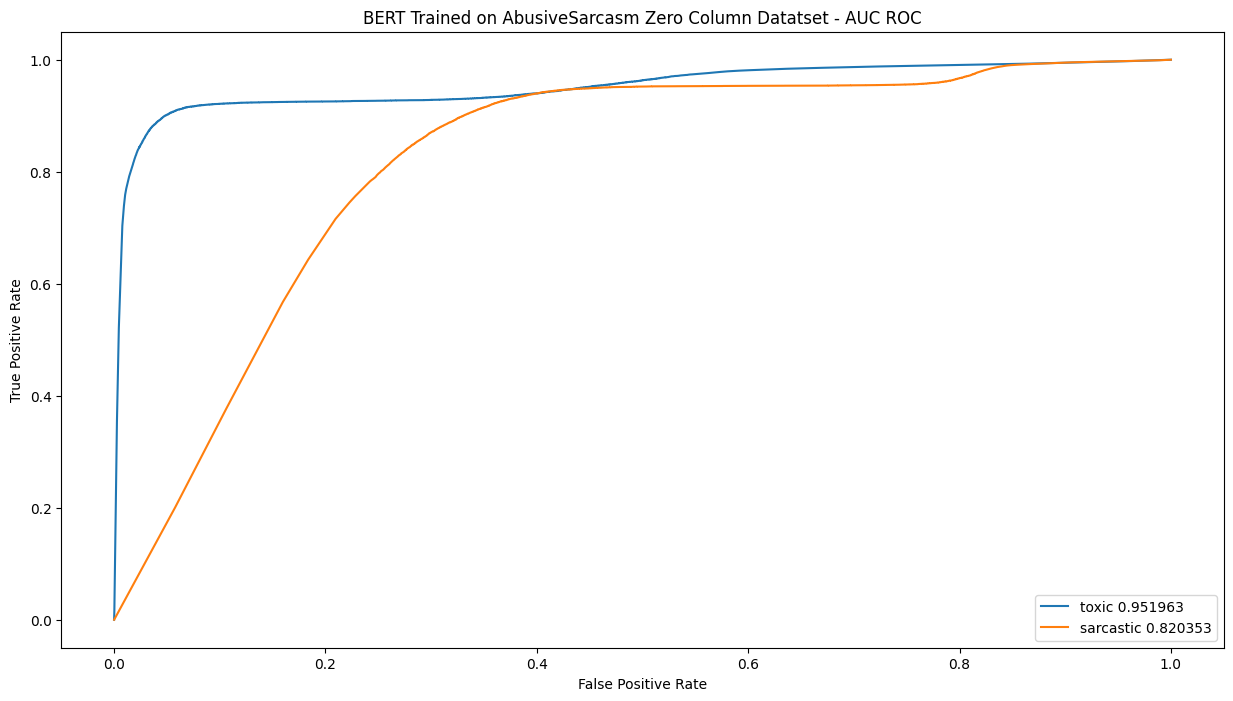

In [ ]:
from sklearn import metrics
plt.figure(figsize=(15, 8))
for i, attribute in enumerate(attributes):
  fpr, tpr, _ = metrics.roc_curve(
      zc_targs[:,i], zc_guess[:, i])
  auc = metrics.roc_auc_score(
      zc_targs[:,i], zc_guess[:, i])
  plt.plot(fpr, tpr, label='%s %g' % (attribute, auc))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.title('BERT Trained on AbusiveSarcasm Zero Column Datatset - AUC ROC')

In [ ]:
zc_label_predictions=[]
for i in range(len(zc_guess)):
  temp=[]
  if zc_guess[i][0] > 0.7:
    temp.append(1) 
  else:
    temp.append(0)
  if zc_guess[i][1] > 0.7:
    temp.append(1) 
  else:
    temp.append(0)
  zc_label_predictions.append(temp)

In [ ]:
import torch

In [ ]:
tensor_zc_label_predictions=torch.Tensor(zc_label_predictions)

In [ ]:
tensor_zc_label_predictions

tensor([[0., 0.],
        [0., 1.],
        [0., 1.],
        ...,
        [0., 1.],
        [1., 0.],
        [1., 0.]])

In [ ]:
list_zc_targs=zc_targs.tolist()

In [ ]:
toxic_pred_match=0
sarcastic_pred_match=0
for i in range(len(zc_label_predictions)):
  if zc_label_predictions[i][0]==list_zc_targs[i][0]:
    toxic_pred_match=toxic_pred_match+1
  if zc_label_predictions[i][1]==list_zc_targs[i][1]:
    sarcastic_pred_match=sarcastic_pred_match+1
print(toxic_pred_match/len(zc_label_predictions))
print(sarcastic_pred_match/len(zc_label_predictions))

0.9508644370358899
0.7232171240860443


In [ ]:
print('arracy on test set {}'.format(accuracy_score(zc_label_predictions, zc_targs)))

arracy on test set 0.6899845941914395


In [ ]:
zc_guess

tensor([[0.6176, 0.6273],
        [0.5000, 0.7311],
        [0.5000, 0.7311],
        ...,
        [0.6184, 0.6265],
        [0.6718, 0.5704],
        [0.5000, 0.7311]])

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(zc_label_predictions, zc_targs))

              precision    recall  f1-score   support

           0       0.88      0.80      0.84     19887
           1       0.91      0.47      0.62     58664

   micro avg       0.90      0.55      0.69     78551
   macro avg       0.89      0.64      0.73     78551
weighted avg       0.90      0.55      0.68     78551
 samples avg       0.36      0.36      0.36     78551



/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Text(0.5, 1.0, 'BERT Trained on AbusiveSarcasm Predict Column Datatset - AUC ROC')

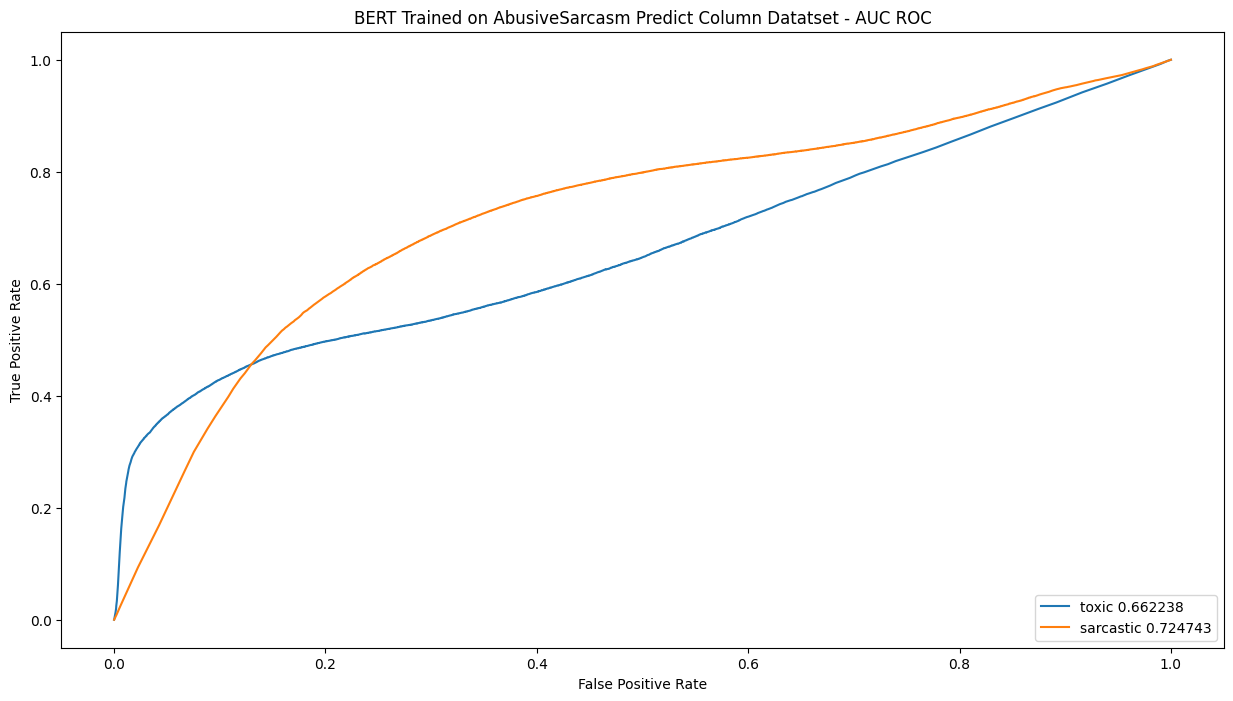

In [ ]:
from sklearn import metrics
plt.figure(figsize=(15, 8))
for i, attribute in enumerate(attributes):
  fpr, tpr, _ = metrics.roc_curve(
      pc_targs[:,i], pc_guess[:, i])
  auc = metrics.roc_auc_score(
      pc_targs[:,i], pc_guess[:, i])
  plt.plot(fpr, tpr, label='%s %g' % (attribute, auc))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.title('BERT Trained on AbusiveSarcasm Predict Column Datatset - AUC ROC')

In [ ]:
pc_guess

tensor([[0.5000, 0.7311],
        [0.6174, 0.6275],
        [0.5000, 0.7311],
        ...,
        [0.5561, 0.6846],
        [0.5682, 0.6738],
        [0.5000, 0.7311]])

In [ ]:
pc_label_predictions=[]
for i in range(len(pc_guess)):
  temp=[]
  if pc_guess[i][0] > 0.7:
    temp.append(1) 
  else:
    temp.append(0)
  if pc_guess[i][1] > 0.7:
    temp.append(1) 
  else:
    temp.append(0)
  pc_label_predictions.append(temp)

In [ ]:
print('arracy on test set {}'.format(accuracy_score(pc_label_predictions, pc_targs)))

arracy on test set 0.5490825800246167


In [ ]:
list_pc_targs=pc_targs.tolist()

In [ ]:
toxic_pred_match=0
sarcastic_pred_match=0
for i in range(len(pc_label_predictions)):
  if pc_label_predictions[i][0]==list_pc_targs[i][0]:
    toxic_pred_match=toxic_pred_match+1
  if pc_label_predictions[i][1]==list_pc_targs[i][1]:
    sarcastic_pred_match=sarcastic_pred_match+1
print(toxic_pred_match/len(pc_label_predictions))
print(sarcastic_pred_match/len(pc_label_predictions))

0.784970777871064
0.684180924511538


This is the classification report 

1st approach/dataset
              precision    recall  f1-score   support

           0       0.88      0.80      0.84     19887
           1       0.91      0.47      0.62     58664

   micro avg       0.90      0.55      0.69     78551
   macro avg       0.89      0.64      0.73     78551
weighted avg       0.90      0.55      0.68     78551
 samples avg       0.36      0.36      0.36     78551 
 
 
 
 
 
 
 2nd approach/dataset
 
 precision    recall  f1-score   support

           0       0.39      0.69      0.50     18923
           1       0.72      0.58      0.64     59602

   micro avg       0.58      0.61      0.59     78525
   macro avg       0.55      0.63      0.57     78525
weighted avg       0.64      0.61      0.61     78525
 samples avg       0.34      0.39      0.36     78525


 provide me with complete breakdown and analysis of these model and also determine why 1st approach did better than 2nd
 

In [ ]:
pc_targs

NameError: ignored

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(pc_label_predictions, pc_targs))

              precision    recall  f1-score   support

           0       0.39      0.69      0.50     18923
           1       0.72      0.58      0.64     59602

   micro avg       0.58      0.61      0.59     78525
   macro avg       0.55      0.63      0.57     78525
weighted avg       0.64      0.61      0.61     78525
 samples avg       0.34      0.39      0.36     78525



/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
import pickle
pickle.dump(zero_col_model, open('/content/gdrive/MyDrive/Untitled folder/zc_model.pkl', 'wb'))
zc_pickled_model = pickle.load(open('/content/gdrive/MyDrive/Untitled folder/zc_model.pkl', 'rb'))

In [ ]:
pickle.dump(pred_col_model, open('/content/gdrive/MyDrive/Untitled folder/pc_model.pkl', 'wb'))
pc_pickled_model = pickle.load(open('/content/gdrive/MyDrive/Untitled folder/pc_model.pkl', 'rb'))

In [ ]:
guess1, targs1 = validation(zc_pickled_model, manual_Tester)

/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:2354: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
<ipython-input-41-2dcf1d0c191a>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'targets': torch.tensor(self.targets[index], dtype=torch.long)


In [ ]:
guess1, targs1 = validation(pc_pickled_model, manual_Tester)

/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:2354: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
<ipython-input-41-2dcf1d0c191a>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'targets': torch.tensor(self.targets[index], dtype=torch.long)


Text(0.5, 1.0, 'BERT Trained on AbusiveSarcasm Predict Column Datatset - AUC ROC')

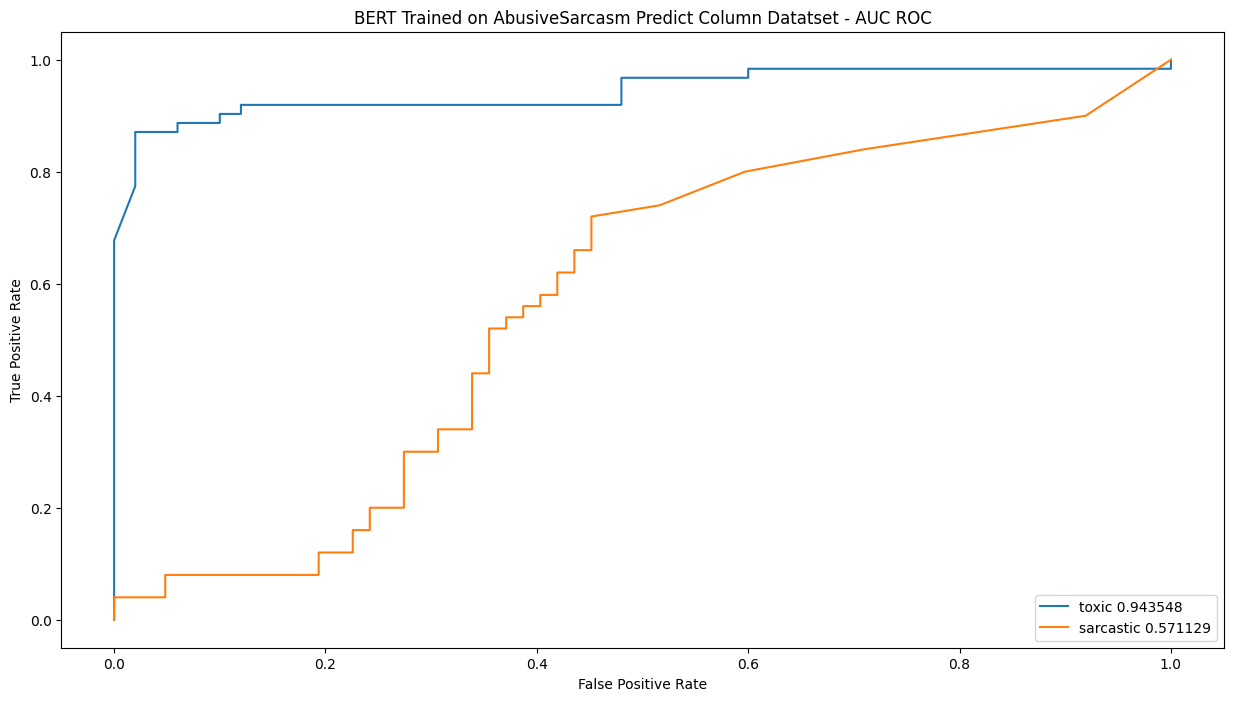

In [ ]:
from sklearn import metrics
plt.figure(figsize=(15, 8))
for i, attribute in enumerate(attributes):
  fpr, tpr, _ = metrics.roc_curve(
      targs1[:,i], guess1[:, i])
  auc = metrics.roc_auc_score(
      targs1[:,i], guess1[:, i])
  plt.plot(fpr, tpr, label='%s %g' % (attribute, auc))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.title('BERT Trained on AbusiveSarcasm Predict Column Datatset - AUC ROC')

In [ ]:
mt_label_predictions=[]
for i in range(len(guess1)):
  temp=[]
  if guess1[i][0] > 0.6:
    temp.append(1) 
  else:
    temp.append(0)
  if guess1[i][1] > 0.60:
    temp.append(1) 
  else:
    temp.append(0)
  mt_label_predictions.append(temp)

In [ ]:
print('arracy on test set {}'.format(accuracy_score(mt_label_predictions, targs1)))

arracy on test set 0.5089285714285714


In [ ]:
!pip install gradio jinja2
import gradio as gr

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 82.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.7/129.7 kB 18.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.8/57.8 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 71.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.5/140.5 kB 19.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 286.2/286.2 kB 34.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.3/75.3 kB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.5/50.5 kB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.0/57.0 kB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.7/45.7 kB 6.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 

In [ ]:
def score_comment(comment):
#    vectorized_comment = vectorizer([comment])
 #   results = model.predict(vectorized_comment)
    
    text = ''
    for idx, col in enumerate(attributes):
        text += '{}: {}\n'.format(col, results[0][idx]>0.5)
    
    return text

In [ ]:
interface = gr.Interface(fn=score_comment, 
                         inputs=gr.inputs.Textbox(lines=3, placeholder='Text to classify'),
                        outputs='text')

/usr/local/lib/python3.9/dist-packages/gradio/inputs.py:27: UserWarning: Usage of gradio.inputs is deprecated, and will not be supported in the future, please import your component from gradio.components
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/gradio/deprecation.py:40: UserWarning: `optional` parameter is deprecated, and it has no effect
  warnings.warn(value)
/usr/local/lib/python3.9/dist-packages/gradio/deprecation.py:40: UserWarning: `numeric` parameter is deprecated, and it has no effect
  warnings.warn(value)


In [ ]:
Sinterface.launch(share=True)

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://d373ad5a988d96470b.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades (NEW!), check out Spaces: https://huggingface.co/spaces
